In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
class CNN_Mnist(nn.Module):
    def __init__(self, input_channel):
        super(CNN_Mnist, self).__init__()

        self.dw1 = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=5),
            nn.ReLU(),
        )

        self.dw2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),            
        )

        self.up1 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5) 
        )

        self.up2 = nn.Sequential(            
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channel, kernel_size=5) 
        )

        self.act = nn.Sigmoid()


    def forward(self, x):
        x = self.dw1(x)
        x= self.dw2(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.act(x)
        return x

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = MNIST(root='~/data',  train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testset = MNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

100%|██████████████████████████████████████| 9912422/9912422 [00:00<00:00, 10488325.36it/s]


Extracting /home/khoidh/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/khoidh/data/MNIST/raw



100%|██████████████████████████████████████████| 28881/28881 [00:00<00:00, 15104201.22it/s]

Extracting /home/khoidh/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/khoidh/data/MNIST/raw



100%|███████████████████████████████████████| 1648877/1648877 [00:00<00:00, 9127395.41it/s]


Extracting /home/khoidh/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/khoidh/data/MNIST/raw



100%|█████████████████████████████████████████████| 4542/4542 [00:00<00:00, 3743471.95it/s]

Extracting /home/khoidh/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/khoidh/data/MNIST/raw

1875 313


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_Mnist(input_channel=1).to(device)

optimizer = Adam(model.parameters(), lr = 0.0001)

loss_fn = nn.MSELoss()

In [5]:
for epoch in range(5):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img = model(train_img)
        train_loss = loss_fn(gen_img, train_img)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img = model(valid_img)

            valid_loss = loss_fn(gen_img, valid_img)

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|███████████████████████████████████████████████████| 313/313 [00:02<00:00, 115.59it/s]


Epoch: 0 - TrainLoss: 0.4822335254351298 - ValidLoss: 0.47150710091804166


100%|███████████████████████████████████████████████████| 313/313 [00:02<00:00, 116.18it/s]


Epoch: 1 - TrainLoss: 0.46443782552083335 - ValidLoss: 0.4707164839624216


100%|███████████████████████████████████████████████████| 313/313 [00:02<00:00, 114.40it/s]


Epoch: 2 - TrainLoss: 0.4639879012266795 - ValidLoss: 0.47044642893270183


100%|███████████████████████████████████████████████████| 313/313 [00:02<00:00, 116.21it/s]


Epoch: 3 - TrainLoss: 0.46381675704320274 - ValidLoss: 0.47032879402462285


100%|███████████████████████████████████████████████████| 313/313 [00:02<00:00, 115.92it/s]

Epoch: 4 - TrainLoss: 0.46372472643852236 - ValidLoss: 0.4702675430157695


100%|██████████████████████████████████████████████████████| 10/10 [00:00<00:00, 11.41it/s]


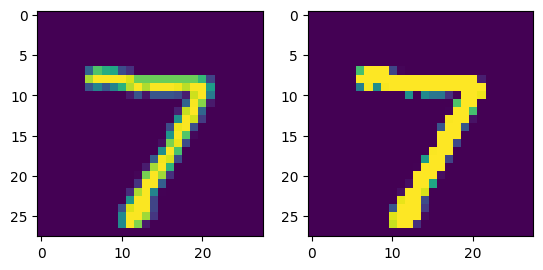

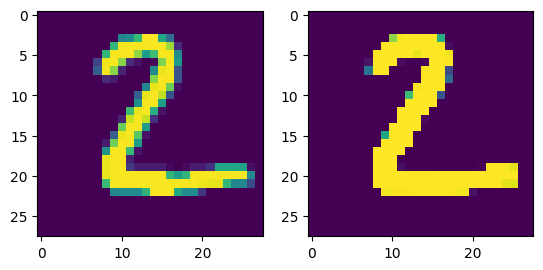

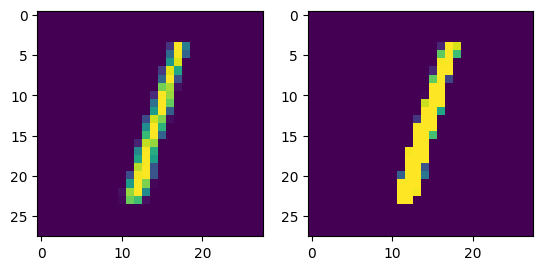

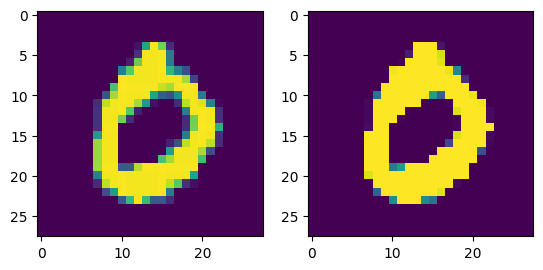

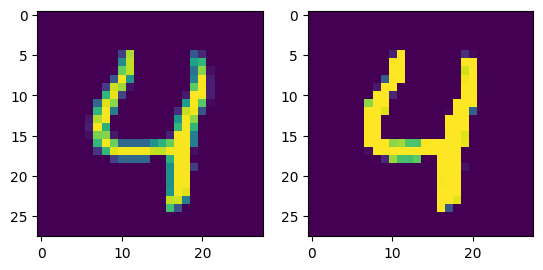

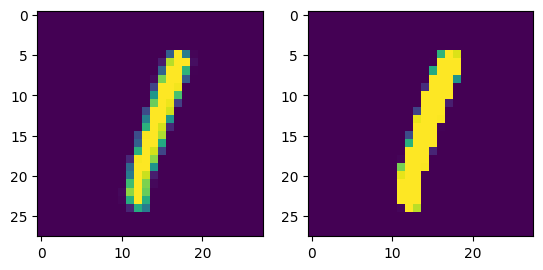

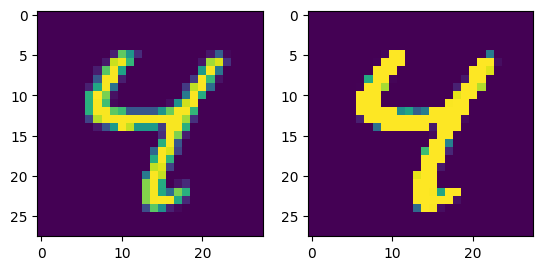

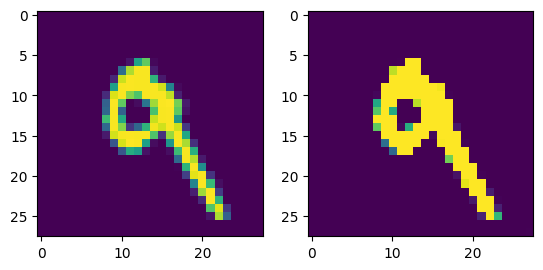

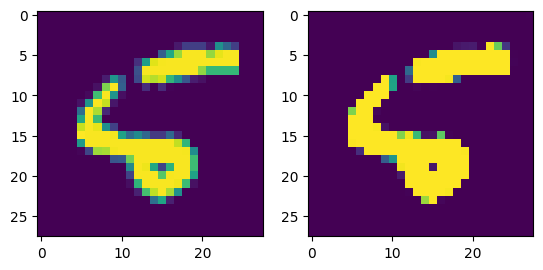

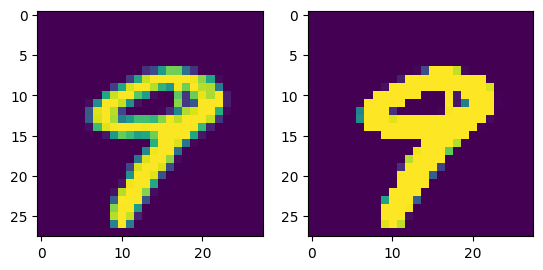

In [6]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())